In [95]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

### Import Data

Read the data from our .csv file.

In [2]:
# join all additional fields
df = pd.read_csv('load_per_country.csv', parse_dates=['DateTime'], index_col = ['DateTime'])
gdp = pd.read_csv('gdp_per_country.csv', parse_dates=['DateTime'], index_col = ['DateTime'])
pop = pd.read_csv('population_per_country.csv', parse_dates=['DateTime'], index_col = ['DateTime'])
tmp =  pd.read_csv('tmp_per_country.csv', parse_dates=['DateTime'], index_col = ['DateTime'])

joined = df.join(gdp, on='DateTime', how='left', lsuffix = '', rsuffix = '_GDP', sort=False)
joined = joined.join(pop, on='DateTime', how='left', lsuffix = '', rsuffix = '_POP', sort=False)
joined = joined.join(tmp, on='DateTime', how='left', lsuffix = '', rsuffix = '_TMP', sort=False)
joined = joined.replace(',','', regex=True)
joined_interpolate = joined.interpolate(method='ffill') # or method='index' works too

In [3]:
# get country-specific datasets

country_datasets = []
country_list = ['PL', 'DE']

for country in country_list:
    country_dataset = joined_interpolate[[country, country + '_GDP', country+ '_POP', country+'_TMP']]
    country_datasets.append([country, country_dataset])

for each in country_datasets:
    name = each[0]
    dataset = each[1]


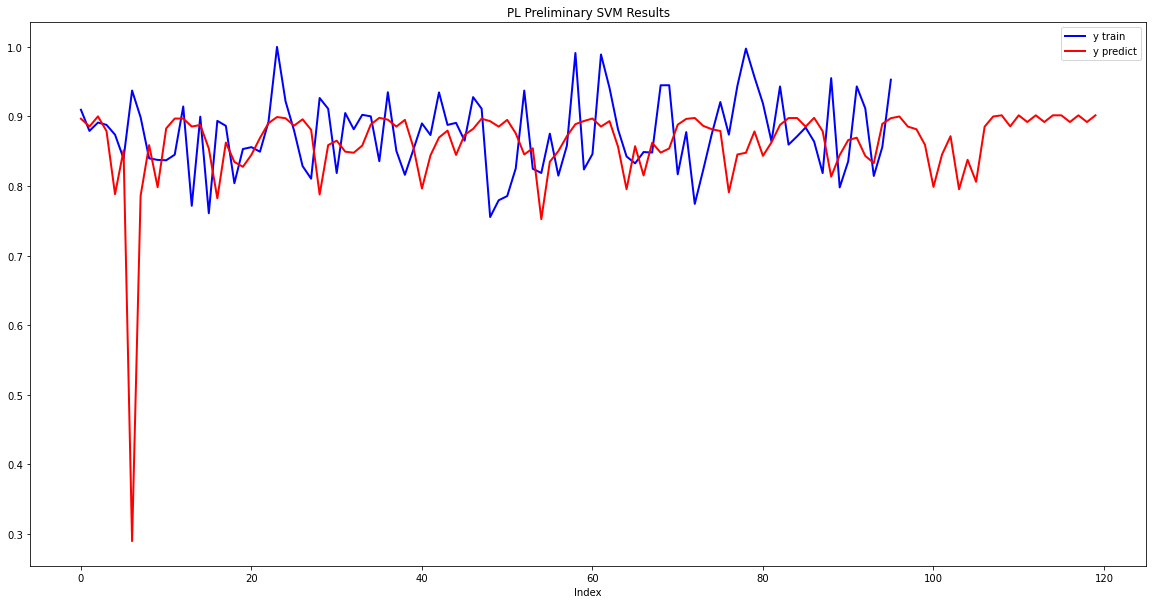

In [32]:
nonan = dataset.dropna()
#nonan = nonan.groupby(pd.Grouper(level='DateTime', axis=0, freq='24H')).sum()


nonan = nonan.groupby(pd.Grouper(level='DateTime', axis=0, freq='M')).sum()

# normalize
nonan = nonan / nonan.max(axis=0) # works

x_train, x_test, y_train, y_test = train_test_split(nonan.iloc[:, 1:].values, nonan['DE'].values,test_size=0.2)

svr = SVR(kernel="poly", degree=25, C=1.0, epsilon=0.1).fit(x_train, y_train)

#svr = SVR(kernel="rbf", gamma=1).fit(x_train, y_train)

#############################
y_train_predict = svr.predict(nonan.iloc[:, 1:].values)

plt.plot( y_train, lw=2, color="blue", label="y train")
plt.plot( y_train_predict, lw=2, color="red", label="y predict")
plt.legend()
plt.title("PL Preliminary SVM Results")
plt.xlabel("Index")
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

In [24]:
score = svr.score(nonan.iloc[:, 1:].values, nonan['DE'].values)
print("R-squared:", score)
print("MSE:", mean_squared_error(nonan['DE'].values, y_train_predict))

R-squared: 0.15095995620014557
MSE: 0.0024961031910877137


In [108]:
def get_best_params(svr, x_train,y_train):

    # Get best parameters
    best_params = []
    grid = [{'kernel': ['linear']}, {'kernel': ['rbf'], 'gamma': [0.1, 0.9, 1, 1.1, 10, 15], 'C': [0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1]}, {'kernel': ['poly'], 'degree': [2, 5, 10, 15,20, 25], 'gamma': [1, 10, 15], 'C': [0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1]}]
    grid_search = GridSearchCV(estimator = svr, param_grid = grid, cv = 3, n_jobs = -1, scoring='explained_variance')

    grid_search.fit(x_train,y_train)
    best_params.append(grid_search.best_params_)
    #print("best parameters are: ", grid_search.best_params_)

    grid_search = GridSearchCV(estimator = svr, param_grid = grid, cv = 3, n_jobs = -1, scoring='neg_mean_squared_error')
    grid_search.fit(x_train,y_train)
    #print("best parameters are: ", grid_search.best_params_)
    best_params.append(grid_search.best_params_)

    grid_search = GridSearchCV(estimator = svr, param_grid = grid, cv = 3, n_jobs = -1, scoring='r2')
    grid_search.fit(x_train,y_train)
    #print("best parameters are: ", grid_search.best_params_)
    best_params.append(grid_search.best_params_)

    
    counts =  {'poly': 0, 'rbf' : 0 , 'linear' : 0}

    for params in best_params:
        counts[params['kernel']] += 1
    
    for types in counts:
        if counts[types] >=2:
            kernel_type = types
        else:
            kernel_type = None    


    if kernel_type != None:
        for params in best_params:
            if params['kernel'] == kernel_type:
                best_parameters = params
    else:
        # if there is no consensus, take a first best best parameters
        best_parameters = best_params[0]

    return best_parameters

In [109]:
def get_svr_best(best_parameters):
    if best_parameters['kernel'] == 'poly':
        svr = SVR(kernel="poly", degree=best_parameters['degree'], C=best_parameters['C'], epsilon=0.1)
    elif best_parameters['kernel'] == 'rbf':
        svr = SVR(kernel="rbf", gamma=best_parameters['gamma'], C=best_parameters['C'])
    elif best_parameters['kernel'] == 'linear':
        svr = SVR(kernel="linear")
    return svr

In [118]:
best_parameters = get_best_params(svr, x_train,y_train)

svr = get_svr_best(best_parameters)

In [119]:
def fun(svr):
    nonan = dataset.dropna()
    #nonan = nonan.groupby(pd.Grouper(level='DateTime', axis=0, freq='24H')).sum()


    nonan = nonan.groupby(pd.Grouper(level='DateTime', axis=0, freq='M')).sum()

    # normalize
    nonan = nonan / nonan.max(axis=0) # works

    x_train, x_test, y_train, y_test = train_test_split(nonan.iloc[:, 1:].values, nonan['DE'].values,test_size=0.2)

    #svr = SVR(kernel="poly", degree=25, C=1.0, epsilon=0.1).fit(x_train, y_train)

    #svr = SVR(kernel="rbf", gamma=1).fit(x_train, y_train)
    

    
    svr = SVR(kernel="poly", degree=25, C=1.0, epsilon=0.1).fit(x_train, y_train)

    #############################
    y_train_predict = svr.predict(nonan.iloc[:, 1:].values)

    plt.plot( y_train, lw=2, color="blue", label="y train")
    plt.plot( y_train_predict, lw=2, color="red", label="y predict")
    plt.legend()
    plt.title("PL Preliminary SVM Results")
    plt.xlabel("Index")
    plt.rcParams["figure.figsize"] = (20,10)
    plt.show()

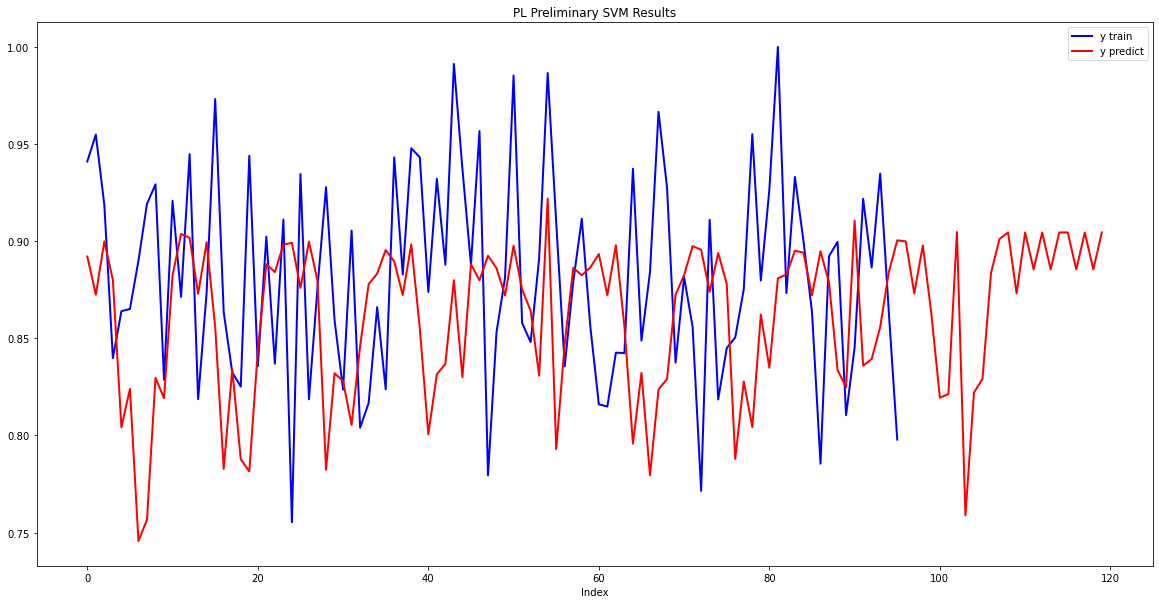

In [120]:
fun(svr)